Top-k eigenvalues: [4.0550456047058105, 4.0550456047058105, 4.0550456047058105]
Trace: 18.52448081970215
Normalized sharpness: 5.251169204711914e-05
Barrier height: 0.9175535440444946


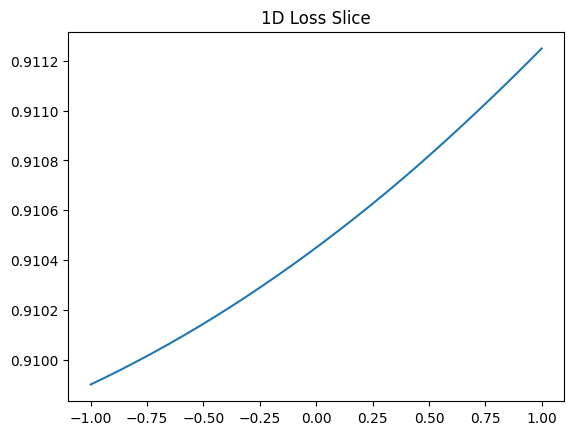

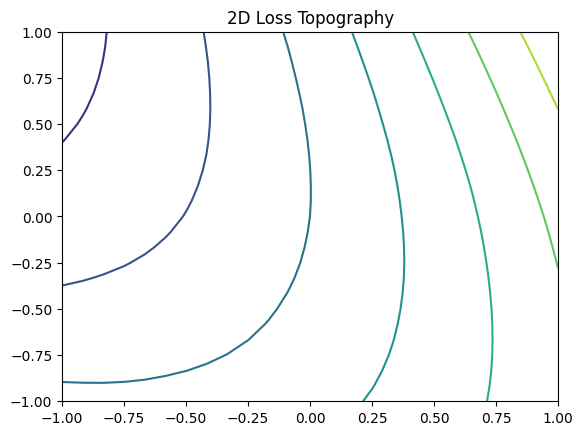

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)

# ---- Synthetic data ----
x = torch.randn(128, 20)
y = torch.randn(128, 1)
data = (x, y)

# ---- Lightweight model ----
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(20, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

modelA = MLP()
modelB = MLP()
loss_fn = nn.MSELoss()
optA = optim.SGD(modelA.parameters(), lr=0.01)
optB = optim.SGD(modelB.parameters(), lr=0.01)

# ---- Train both models slightly differently to simulate 2 minima ----
for _ in range(8):
    optA.zero_grad()
    lossA = loss_fn(modelA(x), y)
    lossA.backward()
    optA.step()

for _ in range(5):
    optB.zero_grad()
    lossB = loss_fn(modelB(x), y)
    lossB.backward()
    optB.step()

# ---- Hessian Vector Product ----
def hvp(loss, params, vecs):
    grads = torch.autograd.grad(loss, params, create_graph=True, retain_graph=True)
    g_v = sum((g*v).sum() for g, v in zip(grads, vecs))
    Hv = torch.autograd.grad(g_v, params, retain_graph=True)
    return Hv

# ---- Top-k Hessian eigenvalues ----
def topk_eigenvals(model, k=3, iters=12):
    params = [p for p in model.parameters() if p.requires_grad]
    eigs = []
    for _ in range(k):
        vecs = [torch.randn_like(p) for p in params]
        vecs = [v/(v.norm()+1e-6) for v in vecs]
        for _ in range(iters):
            loss = loss_fn(model(data[0]), data[1])
            Hv = hvp(loss, params, vecs)
            lam = sum((h*v).sum() for h, v in zip(Hv, vecs)) / sum((v*v).sum() for v in vecs)
            vecs = [h.detach() for h in Hv]
            vecs = [v/(v.norm()+1e-6) for v in vecs]
        eigs.append(lam.item())
    return sorted(eigs, reverse=True)

# ---- Hessian trace (Hutchinson) ----
def trace_est(model, samples=4):
    params = [p for p in model.parameters() if p.requires_grad]
    tr = 0
    for _ in range(samples):
        vecs = [torch.randint(0,2,p.shape)*2.-1. for p in params]
        loss = loss_fn(model(data[0]), data[1])
        Hv = hvp(loss, params, vecs)
        tr += sum((v*h).sum() for v,h in zip(vecs, Hv))
    return (tr/samples).item()

# ---- Normalized sharpness ----
def norm_sharpness(model, eps=1e-2, dirs=12):
    base_loss = loss_fn(model(data[0]), data[1]).item()
    params = [p for p in model.parameters() if p.requires_grad]
    worst = -float("inf")
    directions = [[torch.randn_like(p) for p in params] for _ in range(dirs)]
    directions = [[d/(d.norm()+1e-6) for d in layer] for layer in directions]

    for layer in directions:
        for p,d in zip(params, layer):
            p.data.add_(eps*d*(p.abs()+1e-6))
        loss = loss_fn(model(data[0]), data[1]).item()
        worst = max(worst, loss)
        for p,d in zip(params, layer):
            p.data.sub_(eps*d*(p.abs()+1e-6))
    return worst - base_loss

# ---- Mode connectivity barrier ----
def barrier(modelA, modelB, n=12):
    A = torch.cat([p.data.view(-1) for p in modelA.parameters()])
    B = torch.cat([p.data.view(-1) for p in modelB.parameters()])
    model = MLP()
    vals=[]
    for a in torch.linspace(0,1,n):
        vec = (1-a)*A + a*B
        i=0
        for p in model.parameters():
            size=p.numel()
            p.data = vec[i:i+size].view_as(p)
            i+=size
        vals.append(loss_fn(model(data[0]), data[1]).item())
    return max(vals), vals

# ---- 1D slice ----
def slice1D(model):
    params=list(model.parameters())
    d=[torch.randn_like(p) for p in params]
    d=[v/(v.norm()+1e-6) for v in d]
    al=torch.linspace(-1,1,30)
    losses=[]
    for a in al:
        for p,v in zip(params,d):
            p.data.add_(0.01*a*v)
        losses.append(loss_fn(model(data[0]), data[1]).item())
        for p,v in zip(params,d):
            p.data.sub_(0.01*a*v)
    plt.plot(al.numpy(), losses, label="loss"); plt.title("1D Loss Slice"); plt.show()

# ---- 2D slice ----
def slice2D(model):
    params=list(model.parameters())
    d1=[torch.randn_like(p) for p in params]
    d2=[torch.randn_like(p) for p in params]
    d1=[v/(v.norm()+1e-6) for v in d1]
    d2=[v/(v.norm()+1e-6) for v in d2]
    grid=torch.linspace(-1,1,25)
    Z=np.zeros((25,25))
    for i,a in enumerate(grid):
        for j,b in enumerate(grid):
            for p,v1,v2 in zip(params,d1,d2):
                p.data.add_(0.01*a*v1+0.01*b*v2)
            Z[j,i]=loss_fn(model(data[0]), data[1]).item()
            for p,v1,v2 in zip(params,d1,d2):
                p.data.sub_(0.01*a*v1+0.01*b*v2)
    plt.contour(grid.numpy(), grid.numpy(), Z);plt.title("2D Loss Topography");plt.show()

# ---- Run probes ----
print("Top-k eigenvalues:", topk_eigenvals(modelA))
print("Trace:", trace_est(modelA))
print("Normalized sharpness:", norm_sharpness(modelA))
(max_loss, path_losses) = barrier(modelA, modelB)
print("Barrier height:", max_loss)

slice1D(modelA)
slice2D(modelA)


ResNet Trace: 23794.703125
ResNet Top-k eigvals: [30.555761337280273, 30.554471969604492, 30.548908233642578, 30.520437240600586, 30.453123092651367]
ResNet Barrier height: 2.3620429039001465


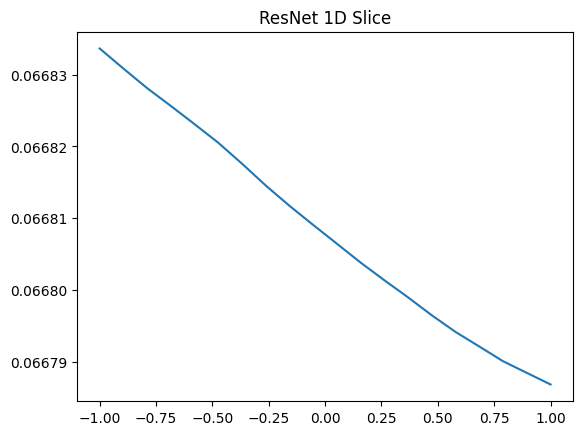

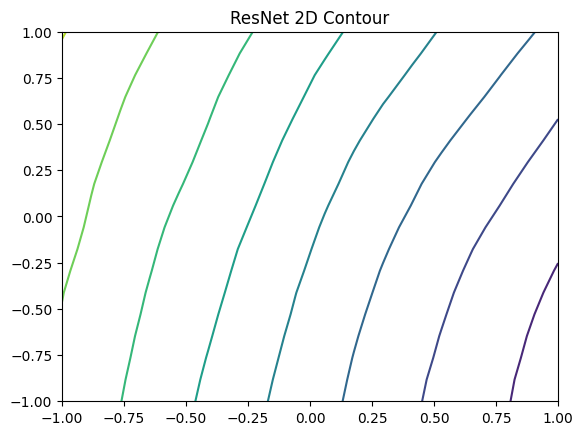

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)

# ---- Synthetic image data (acts like CIFAR-10: 3x32x32) ----
x = torch.randn(64, 3, 32, 32)
y = torch.randint(0, 10, (64,))
data = (x, y)

# ---- Model A and B (2 different initialization minima) ----
modelA = models.resnet18(num_classes=10)
modelB = models.resnet18(num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optA = optim.SGD(modelA.parameters(), lr=0.01, momentum=0.9)
optB = optim.SGD(modelB.parameters(), lr=0.006, momentum=0.8)

# ---- Train a few steps to simulate 2 converged solutions in different basins ----
for _ in range(6):
    optA.zero_grad()
    lossA = loss_fn(modelA(x), y)
    lossA.backward()
    optA.step()

for _ in range(4):
    optB.zero_grad()
    lossB = loss_fn(modelB(x), y)
    lossB.backward()
    optB.step()

# ---- Geometry Probing ----
def hvp(loss, params, vecs):
    grads = torch.autograd.grad(loss, params, create_graph=True, retain_graph=True)
    g_v = sum((g*v).sum() for g, v in zip(grads, vecs))
    Hv = torch.autograd.grad(g_v, params, retain_graph=True)
    return Hv

def trace_est(model, samples=5):
    params = [p for p in model.parameters() if p.requires_grad]
    trace = 0
    for _ in range(samples):
        vecs = [torch.randint(0,2,p.shape)*2.-1 for p in params]  # Rademacher {-1, +1}
        loss = loss_fn(model(data[0]), data[1])
        Hv = hvp(loss, params, vecs)
        trace += sum((v*h).sum() for v,h in zip(vecs, Hv))
    return (trace/samples).item()

def topk_eigenvals(model, k=5, iters=10):
    params = [p for p in model.parameters() if p.requires_grad]
    eigs = []
    for _ in range(k):
        vecs = [torch.randn_like(p) for p in params]
        vecs = [v/(v.norm()+1e-6) for v in vecs]
        for _ in range(iters):
            loss = loss_fn(model(data[0]), data[1])
            Hv = hvp(loss, params, vecs)
            lam = sum((h*v).sum() for h, v in zip(Hv, vecs)) / sum((v*v).sum() for v in vecs)
            vecs = [h.detach() for h in Hv]
            vecs = [v/(v.norm()+1e-6) for v in vecs]
        eigs.append(lam.item())
    return sorted(eigs, reverse=True)

def interpolation_barrier(modelA, modelB, n=10):
    A = torch.cat([p.data.view(-1) for p in modelA.parameters()])
    B = torch.cat([p.data.view(-1) for p in modelB.parameters()])
    model = models.resnet18(num_classes=10)
    losses = []
    for a in torch.linspace(0,1,n):
        vec = (1-a)*A + a*B
        i = 0
        for p in model.parameters():
            size=p.numel()
            p.data = vec[i:i+size].view_as(p)
            i+=size
        losses.append(loss_fn(model(data[0]), data[1]).item())
    return max(losses), losses

# ---- 1D & 2D Slices ----
def slice1D(model):
    params=list(model.parameters())
    d=[torch.randn_like(p) for p in params]
    d=[v/(v.norm()+1e-6) for v in d]
    alphas=torch.linspace(-1,1,20)
    losses=[]
    for a in alphas:
        for p,v in zip(params,d): p.data.add_(0.002*a*v)
        losses.append(loss_fn(model(x), y).item())
        for p,v in zip(params,d): p.data.sub_(0.002*a*v)
    plt.plot(alphas.numpy(), losses); plt.title("ResNet 1D Slice"); plt.show()

def slice2D(model):
    params=list(model.parameters())
    d1=[torch.randn_like(p) for p in params]
    d2=[torch.randn_like(p) for p in params]
    d1=[v/(v.norm()+1e-6) for v in d1]
    d2=[v/(v.norm()+1e-6) for v in d2]
    grid=torch.linspace(-1,1,18)
    Z=np.zeros((18,18))
    for i,a in enumerate(grid):
        for j,b in enumerate(grid):
            for p,v1,v2 in zip(params,d1,d2):
                p.data.add_(0.002*a*v1 + 0.002*b*v2)
            Z[j,i]=loss_fn(model(x), y).item()
            for p,v1,v2 in zip(params,d1,d2):
                p.data.sub_(0.002*a*v1 + 0.002*b*v2)
    plt.contour(grid.numpy(), grid.numpy(), Z); plt.title("ResNet 2D Contour"); plt.show()

# ---- Run everything ----
print("ResNet Trace:", trace_est(modelA))
print("ResNet Top-k eigvals:", topk_eigenvals(modelA))
(h, path_losses) = interpolation_barrier(modelA, modelB)
print("ResNet Barrier height:", h)

slice1D(modelA)
slice2D(modelA)


Transformer Trace: 0.05539940297603607
Transformer Barrier height: 0.6732901334762573


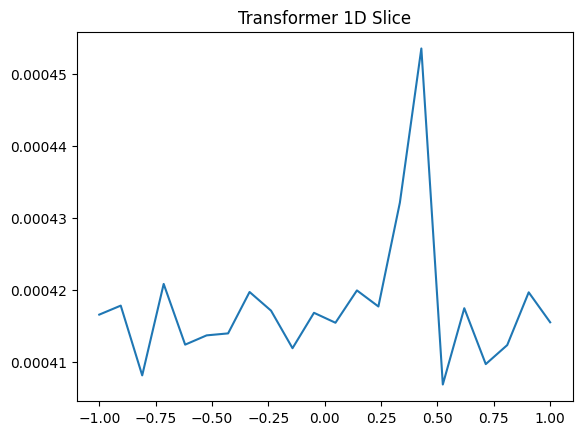

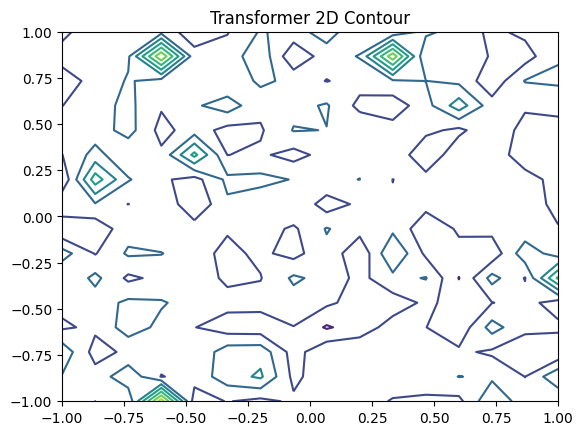

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)

# ---- Synthetic sequence task data ----
seq = torch.randint(0, 100, (32,10))  # (batch, tokens)
label = torch.randint(0, 2, (32,))
data = (seq, label)

# ---- Tiny Transformer Encoder ----
class TinyTransformer(nn.Module):
    def __init__(self, vocab=100, dim=32, heads=4, depth=2, num_classes=2):
        super().__init__()
        self.embed = nn.Embedding(vocab, dim)
        self.pos = nn.Parameter(torch.randn(1,10,dim))
        enc_layer = nn.TransformerEncoderLayer(dim, heads, dim*2, batch_first=True, activation="gelu")
        self.encoder = nn.TransformerEncoder(enc_layer, depth)
        self.head = nn.Linear(dim, num_classes)

    def forward(self, x):
        e = self.embed(x) + self.pos
        h = self.encoder(e)
        pooled = h.mean(dim=1)
        return self.head(pooled)

modelA = TinyTransformer()
modelB = TinyTransformer()
loss_fn = nn.CrossEntropyLoss()
optA = optim.AdamW(modelA.parameters(), lr=3e-3)
optB = optim.AdamW(modelB.parameters(), lr=1.5e-3)

# Train both differently
for _ in range(40):
    optA.zero_grad()
    lossA = loss_fn(modelA(seq), label)
    lossA.backward()
    optA.step()

for _ in range(20):
    optB.zero_grad()
    lossB = loss_fn(modelB(seq), label)
    lossB.backward()
    optB.step()

# ---- Probing functions reused ----
def hvp(loss, params, vecs):
    grads = torch.autograd.grad(loss, params, create_graph=True, retain_graph=True)
    g_v = sum((g*v).sum() for g, v in zip(grads, vecs))
    return torch.autograd.grad(g_v, params, retain_graph=True)

def trace_est(model, samples=4):
    params=[p for p in model.parameters() if p.requires_grad]
    tr=0
    for _ in range(samples):
        v=[torch.randint(0,2,p.shape)*2.-1 for p in params]
        loss=loss_fn(model(seq), label)
        Hv=hvp(loss,params,v)
        tr+=sum((vi*hvi).sum() for vi,hvi in zip(v,Hv))
    return (tr/samples).item()

def barrier(modelA, modelB, n=12):
    A=torch.cat([p.data.view(-1) for p in modelA.parameters()])
    B=torch.cat([p.data.view(-1) for p in modelB.parameters()])
    model=TinyTransformer()
    losses=[]
    for a in torch.linspace(0,1,n):
        vec=(1-a)*A+a*B
        i=0
        for p in model.parameters():
            s=p.numel(); p.data=vec[i:i+s].view_as(p); i+=s
        losses.append(loss_fn(model(seq),label).item())
    return max(losses), losses

def slice1D(model):
    params=list(model.parameters())
    d=[torch.randn_like(p) for p in params]
    d=[v/(v.norm()+1e-6) for v in d]
    alphas=torch.linspace(-1,1,22)
    losses=[]
    for a in alphas:
        for p,v in zip(params,d): p.data.add_(0.001*a*v)
        losses.append(loss_fn(model(seq), label).item())
        for p,v in zip(params,d): p.data.sub_(0.001*a*v)
    plt.plot(alphas.numpy(), losses); plt.title("Transformer 1D Slice"); plt.show()

def slice2D(model):
    params=list(model.parameters())
    d1=[torch.randn_like(p) for p in params]
    d2=[torch.randn_like(p) for p in params]
    d1=[v/(v.norm()+1e-6) for v in d1]
    d2=[v/(v.norm()+1e-6) for v in d2]
    grid=torch.linspace(-1,1,16)
    Z=np.zeros((16,16))
    for i,a in enumerate(grid):
        for j,b in enumerate(grid):
            for p,v1,v2 in zip(params,d1,d2):
                p.data.add_(0.003*a*v1 + 0.001*b*v2)
            Z[j,i]=loss_fn(model(seq), label).item()
            for p,v1,v2 in zip(params,d1,d2):
                p.data.sub_(0.003*a*v1 + 0.001*b*v2)
    plt.contour(grid.numpy(), grid.numpy(), Z); plt.title("Transformer 2D Contour"); plt.show()

# ---- Run ----
print("Transformer Trace:", trace_est(modelA))
(h, losses)=barrier(modelA, modelB)
print("Transformer Barrier height:", h)

slice1D(modelA)
slice2D(modelA)
